In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import os
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential
from tensorflow.python.keras import backend as K
from collections import Counter
import random

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available:  0


In [3]:
# Load the dataset without any predefined batch size
train_data = tf.keras.utils.image_dataset_from_directory(
    'images/train',
    labels='inferred',
    label_mode='int',
    batch_size=None,  # Load as unbatched dataset
    image_size=(48, 48),  # Resize images to standard size
    seed=42 
)

Found 28679 files belonging to 7 classes.


In [4]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [5]:
test_data = keras.utils.image_dataset_from_directory(
    directory = 'images/test',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = 120,
    image_size = (48, 48),
    seed=42 
)

Found 7177 files belonging to 7 classes.


In [6]:
# Class names
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
# Extract data from train dataset
def extract_images_and_labels(dataset):
    X, y = [], []
    for image, label in dataset:
        X.append(image.numpy())
        y.append(label.numpy())
    return np.array(X), np.array(y)

# Assuming train_data is loaded correctly
X, y = extract_images_and_labels(train_data)

In [8]:
print(f'X shape before augmentation: {X.shape}')
print(f'y shape before augmentation: {y.shape}')

X shape before augmentation: (28679, 48, 48, 3)
y shape before augmentation: (28679,)


In [9]:
def data_augmentation(X, y, target_count=2000, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                      zoom_range=0.1, brightness_range=(0.95, 1.05), horizontal_flip=True, vertical_flip=True, fill_mode='nearest'):
    # Initialize ImageDataGenerator
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        brightness_range=brightness_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        fill_mode=fill_mode
    )

    balanced_X = []
    balanced_y = []
    
    unique_classes = np.unique(y)
    # For each class, augment until reaching the target count
    for class_label in unique_classes:
        class_indices = np.where(y == class_label)[0]
        class_images = X[class_indices]
        class_labels = y[class_indices]
        num_images = class_images.shape[0]

        # Calculate how many augmentations are needed
        augmentations_needed = target_count - num_images
        if augmentations_needed >0:
            # Add original images to balanced dataset
            balanced_X.extend(class_images)
            balanced_y.extend(class_labels)
    
            # Calculate how many augmentations are needed for this class
            augmentations_needed = target_count - num_images
    
            # Augment images until we reach the target count
            while augmentations_needed > 0:
                for img, label in zip(class_images, class_labels):
                    if augmentations_needed <= 0:
                        break
                    img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels)
                    label = label.reshape((1,))  # Reshape to a single label
                    augmented_img = next(datagen.flow(img))  # Generate an augmented image
                    balanced_X.append(augmented_img.squeeze())  # Add augmented image to list
                    balanced_y.append(label.squeeze())  # Add label to list
                    augmentations_needed -= 1
        else:
            balanced_X.extend(class_images[:target_count])
            balanced_y.extend(class_labels[:target_count])

    balanced_X = np.array(balanced_X)
    balanced_y = np.array(balanced_y)

    return balanced_X, balanced_y

In [10]:
X_augmented, y_augmented = data_augmentation(X, y, target_count=500)

In [11]:
print(f'X shape after augmentation: {X_augmented.shape}')
print(f'y shape after augmentation: {y_augmented.shape}')

X shape after augmentation: (3500, 48, 48, 3)
y shape after augmentation: (3500,)


In [12]:
#convert to channel 1
X_augmented = X_augmented[:, :, :, [0]]

In [13]:
Counter(y_augmented)

Counter({np.int32(0): 500,
         np.int32(1): 500,
         np.int32(2): 500,
         np.int32(3): 500,
         np.int32(4): 500,
         np.int32(5): 500,
         np.int32(6): 500})

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array(X_augmented)  # Images
y = np.array(y_augmented)  # Labels

In [15]:
# Parameters for stratified shuffle split
batch_size = 126
n_splits = 1  # Number of splits you want
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=None, train_size=batch_size / len(y))

In [16]:
# Generate stratified batches
batches = []
for _, batch_indices in sss.split(X, y):
    batch_images = X[batch_indices].astype(np.float32)/ 255.0  # Ensure images are float32
    batch_labels = y[batch_indices].astype(np.int32)    # Ensure labels are int32
    batches.append((batch_images, batch_labels))

In [17]:
# Convert to TensorFlow Dataset
final_dataset = tf.data.Dataset.from_tensor_slices(
    (
        tf.convert_to_tensor([batch[0] for batch in batches], dtype=tf.float32),  # Images as float32
        tf.convert_to_tensor([batch[1] for batch in batches], dtype=tf.int32),   # Labels as int32
    )
)

In [18]:
# Inspect the first batch
for batch in final_dataset.take(1):
    print(f"Image batch shape: {batch[0].shape}, Label batch shape: {batch[1].shape}")
    print(batch[1])

Image batch shape: (3375, 48, 48, 1), Label batch shape: (3375,)
tf.Tensor([5 1 6 ... 5 0 2], shape=(3375,), dtype=int32)


In [19]:
# Split into training and validation sets
validation_split = 0.2
num_batches = len(batches)

val_dataset = final_dataset.take(int(num_batches * validation_split))
train_dataset = final_dataset.skip(int(num_batches * validation_split))

In [20]:
num_classes = 7

In [21]:
model_file = "my_model.keras"

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

C:\Users\301340153\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [23]:
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 879,623 (3.36 MB)

 Trainable params: 879,623 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#Release memory
train_data =0
X = y = 0
balanced_X = balanced_y = 0
X_augmented = y_augmented = 0
final_dataset = 0

In [26]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.1473 - loss: 1.9461
Epoch 2/50


C:\Users\301340153\AppData\Local\miniconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.1452 - loss: 1.9460
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.1493 - loss: 1.9456
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.1467 - loss: 1.9456
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1544 - loss: 1.9452
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1336 - loss: 1.9457
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1413 - loss: 1.9460
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1437 - loss: 1.9455
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1458 - loss: 1.9464
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1375 - loss: 1.9449
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1434 - loss: 1.9455
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1473 - loss: 1.9449
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.1490 - loss: 1.9454
Epoch 14/50
1/1 ━

In [27]:
model.save(model_file)

KeyError: 'val_accuracy'

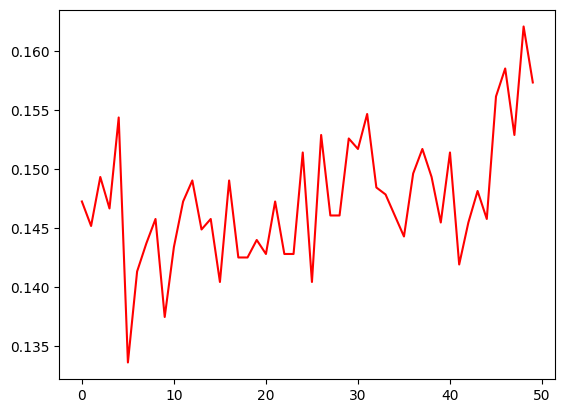

In [28]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

KeyError: 'val_loss'

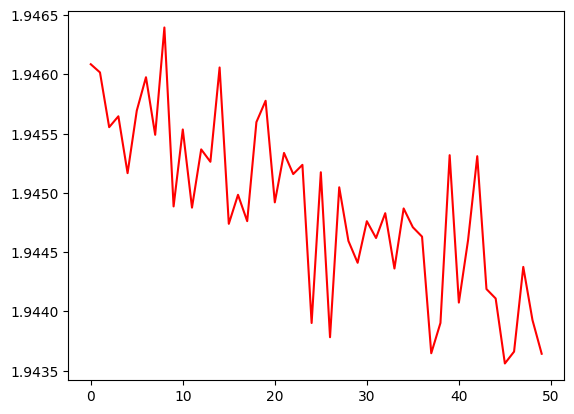

In [29]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

In [30]:
# Evaluate model
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.1146 - loss: 18.0028
Test Accuracy: 11.58%
